In [12]:
import json
import os

# Define the base directory for the problem files
problem_dir = "math-rollouts/deepseek-r1-distill-llama-8b/temperature_0.6_top_p_0.95/correct_base_solution/problem_330"
#math-rollouts/deepseek-r1-distill-llama-8b/temperature_0.6_top_p_0.95/correct_base_solution/problem_330/base_solution.json

# The directory containing the solution file
# chunk_dir = "chunk_0"
# The name of the solution file
chunk_filename = "base_solution.json"

# Construct the full path to the solutions.json file
chunk_path = os.path.join(problem_dir, chunk_filename)

try:
    with open(chunk_path, 'r') as f:
        # Load the JSON content from the file
        chunk_data = json.load(f)

    print(f"Content of {chunk_filename}:")
    # Pretty-print the JSON object for better readability
    print(json.dumps(chunk_data, indent=2))

except FileNotFoundError:
    print(f"Error: The file {chunk_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: The file {chunk_path} is not a valid JSON file.")

Content of base_solution.json:
{
  "prompt": "Solve this math problem step by step. You MUST put your final answer in \\boxed{}. Problem: Compute\n\n$3(1+3(1+3(1+3(1+3(1+3(1+3(1+3(1+3(1+3)))))))))$ Solution: \n<think>\n",
  "solution": "Alright, so I've got this math problem here that I need to solve. It's a nested expression with a bunch of threes and parentheses. Let me write it down to get a better look:\n\n3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3(1 + 3)))))))))\n\nWow, that's a lot of parentheses! Okay, so I need to compute this step by step. I think the best way to approach it is to start from the innermost parentheses and work my way outwards. That usually makes nested expressions easier to handle. Let me try that.\n\nFirst, let's identify the innermost part. It seems like the last set of parentheses is (1 + 3). Let me compute that first.\n\n1 + 3 = 4\n\nOkay, so the innermost part simplifies to 4. Now, replacing that in the expression, the next layer out would be 3(1 + 

In [13]:
input_text = chunk_data["full_cot"]

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, AutoModelForCausalLM, pipeline

import torch


model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B" # Or any other suitable model

mname = model_name

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Important: Add a pad token if the tokenizer doesn't have one, especially for decoder models.

if tokenizer.pad_token is None:

    tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load the model with `output_attentions=True`
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True, torch_dtype=torch.bfloat16, device_map="auto")

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]



In [14]:
# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

# Access attention weights
attention_weights = outputs.attentions

In [15]:
attention_weights = outputs.attentions

In [10]:
# check real attention scores
for layer in range(32):
    layer_attention = attention_weights[layer]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    for head in range(32):
        # Get the specific head's attention matrix and detach from the graph
        head_attention = head_attention = attention_pattern[head].detach().to(torch.float32).cpu().numpy()
        sum_attention = head_attention.sum(axis=(1))
        print(f"Layer {layer}, Head {head}: {sum_attention}")


Layer 0, Head 0: [1.         1.0004883  0.9995117  ... 1.0003573  0.99996865 1.0009204 ]
Layer 0, Head 1: [1.        1.0014648 0.998291  ... 1.0003076 1.0000572 0.9999357]
Layer 0, Head 2: [1.         1.0014648  0.9995117  ... 0.99974346 1.0010469  0.99994653]
Layer 0, Head 3: [1.        1.        1.        ... 0.9999404 1.0007172 0.9993855]
Layer 0, Head 4: [1.        1.0004883 0.9991455 ... 1.0002215 1.0000865 1.0004596]
Layer 0, Head 5: [1.         0.99902344 1.0014648  ... 0.99995345 1.000308   0.9999411 ]
Layer 0, Head 6: [1.        1.        1.        ... 1.0001962 0.9997057 1.0000097]
Layer 0, Head 7: [1.        1.0009766 0.9984131 ... 1.0003548 1.0000226 1.0000203]
Layer 0, Head 8: [1.         1.0009766  1.0004883  ... 0.9999478  0.99983406 0.99997604]
Layer 0, Head 9: [1.        0.998291  0.9992676 ... 0.9997413 0.9998176 1.000044 ]
Layer 0, Head 10: [1.         1.0009766  1.0004883  ... 1.0002431  0.9985289  0.99931955]
Layer 0, Head 11: [1.         0.99902344 1.0009766  ... 

In [16]:
attention_weights = outputs.attentions

# Print the shape of the attention weights for each layer
print("Attention weights shape for each layer:")
for i, layer_attentions in enumerate(attention_weights):
    print(f"Layer {i}: {layer_attentions.shape}")

Attention weights shape for each layer:
Layer 0: torch.Size([1, 32, 3325, 3325])
Layer 1: torch.Size([1, 32, 3325, 3325])
Layer 2: torch.Size([1, 32, 3325, 3325])
Layer 3: torch.Size([1, 32, 3325, 3325])
Layer 4: torch.Size([1, 32, 3325, 3325])
Layer 5: torch.Size([1, 32, 3325, 3325])
Layer 6: torch.Size([1, 32, 3325, 3325])
Layer 7: torch.Size([1, 32, 3325, 3325])
Layer 8: torch.Size([1, 32, 3325, 3325])
Layer 9: torch.Size([1, 32, 3325, 3325])
Layer 10: torch.Size([1, 32, 3325, 3325])
Layer 11: torch.Size([1, 32, 3325, 3325])
Layer 12: torch.Size([1, 32, 3325, 3325])
Layer 13: torch.Size([1, 32, 3325, 3325])
Layer 14: torch.Size([1, 32, 3325, 3325])
Layer 15: torch.Size([1, 32, 3325, 3325])
Layer 16: torch.Size([1, 32, 3325, 3325])
Layer 17: torch.Size([1, 32, 3325, 3325])
Layer 18: torch.Size([1, 32, 3325, 3325])
Layer 19: torch.Size([1, 32, 3325, 3325])
Layer 20: torch.Size([1, 32, 3325, 3325])
Layer 21: torch.Size([1, 32, 3325, 3325])
Layer 22: torch.Size([1, 32, 3325, 3325])
Laye

In [17]:
import numpy as np

In [18]:
def get_vertical_scores(
    avg_mat: np.ndarray,
    proximity_ignore: int = 20,
    control_depth: bool = True,
    score_type: str = "mean",
) -> np.ndarray:
    """
    Calculate vertical attention scores from an averaged attention matrix.
    """
    n = avg_mat.shape[0]
    trius = np.triu_indices_from(avg_mat, k=1)
    avg_mat = avg_mat.copy()
    avg_mat[trius] = np.nan
    trils = np.triu_indices_from(avg_mat, k=-proximity_ignore + 1)
    avg_mat[trils] = np.nan

    if control_depth:
        per_row = np.sum(~np.isnan(avg_mat), axis=1)
        avg_mat = stats.rankdata(avg_mat, axis=1, nan_policy="omit") / per_row[:, None]

    n = avg_mat.shape[-1]
    vert_scores = []
    for i in range(n):
        vert_lines = avg_mat[i + proximity_ignore :, i]
        if score_type == "mean":
            vert_score = np.nanmean(vert_lines)
        elif score_type == "median":
            vert_score = np.nanmedian(vert_lines)
        else:
            raise ValueError(f"Unknown score_type: {score_type}")
        vert_scores.append(vert_score)
    return np.array(vert_scores)

In [19]:
all_layer_head_scores = []
for layer, layer_attn in enumerate(attention_weights):
    layer_scores = []
    for head in range(layer_attn.shape[1]):
        avg_mat = layer_attn[0, head].detach().to(torch.float32).cpu().numpy()
        vert_scores = get_vertical_scores(avg_mat, proximity_ignore=4, control_depth=False, score_type="mean")
        layer_scores.append(vert_scores)
    all_layer_head_scores.append(layer_scores)
all_layer_head_scores = np.array(all_layer_head_scores)  # shape: [num_layers, num_heads, seq_len - proximity_ignore]

print(all_layer_head_scores.shape)

/tmp/ipykernel_3554811/1493485245.py:26: RuntimeWarning: Mean of empty slice
  vert_score = np.nanmean(vert_lines)


(32, 32, 3325)


In [20]:
from scipy import stats
def get_3d_ar_kurtosis(layer_head_vert_scores: np.ndarray) -> np.ndarray:
    layer_head_kurts = stats.kurtosis(
        layer_head_vert_scores, axis=2, fisher=True, bias=True, nan_policy="omit"
    )  # NaNs from the proximity ignorance
    return layer_head_kurts

# Compute kurtosis for all [layer][head] using vertical scores
layer_head_kurtosis = get_3d_ar_kurtosis(all_layer_head_scores)
print('Kurtosis shape:', layer_head_kurtosis.shape)
print(layer_head_kurtosis)

Kurtosis shape: (32, 32)
[[ 258.62893536  604.88989173 2489.78832809 ... 3306.09810706
  3306.99707812 3310.68054525]
 [3269.12061005 3315.70498374 3315.27292747 ... 3227.84871044
  3311.33377638 3313.1016395 ]
 [3312.13211589 3314.25376148 3304.62134831 ... 3268.93179474
  3314.52353338 3312.96820405]
 ...
 [3313.91771766 3309.73378565 3315.41659647 ... 3035.77985373
  3276.98459069 3311.7976909 ]
 [2626.25456178 3275.38788134 3287.02868026 ... 3303.01060608
  3292.90826847 3120.03892345]
 [3287.61044035 3287.71816415 3264.56495553 ... 3203.21100153
  3241.62140774 2743.03808727]]


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
# Find the top 20 kurtosis scores and their (layer, head) indices
import numpy as np
num_layers, num_heads = layer_head_kurtosis.shape
flat_kurtosis = layer_head_kurtosis.flatten()
top_indices = np.argpartition(flat_kurtosis, -20)[-20:]
top_sorted_indices = top_indices[np.argsort(flat_kurtosis[top_indices])[::-1]]
print("Top 20 kurtosis scores with (layer, head):")
for idx in top_sorted_indices:
    layer = idx // num_heads
    head = idx % num_heads
    score = layer_head_kurtosis[layer, head]
    print(f"Layer {layer}, Head {head}: Kurtosis = {score:.4f}")

Top 20 kurtosis scores with (layer, head):
Layer 4, Head 12: Kurtosis = 3315.9965
Layer 1, Head 20: Kurtosis = 3315.9964
Layer 3, Head 18: Kurtosis = 3315.9962
Layer 25, Head 20: Kurtosis = 3315.9770
Layer 3, Head 17: Kurtosis = 3315.9696
Layer 3, Head 4: Kurtosis = 3315.9577
Layer 29, Head 24: Kurtosis = 3315.9563
Layer 25, Head 22: Kurtosis = 3315.9508
Layer 1, Head 26: Kurtosis = 3315.9362
Layer 1, Head 13: Kurtosis = 3315.9168
Layer 1, Head 18: Kurtosis = 3315.9025
Layer 29, Head 27: Kurtosis = 3315.9022
Layer 29, Head 25: Kurtosis = 3315.8783
Layer 23, Head 29: Kurtosis = 3315.8715
Layer 29, Head 26: Kurtosis = 3315.8692
Layer 28, Head 5: Kurtosis = 3315.8079
Layer 28, Head 22: Kurtosis = 3315.8039
Layer 22, Head 20: Kurtosis = 3315.7933
Layer 24, Head 9: Kurtosis = 3315.7827
Layer 7, Head 5: Kurtosis = 3315.7681


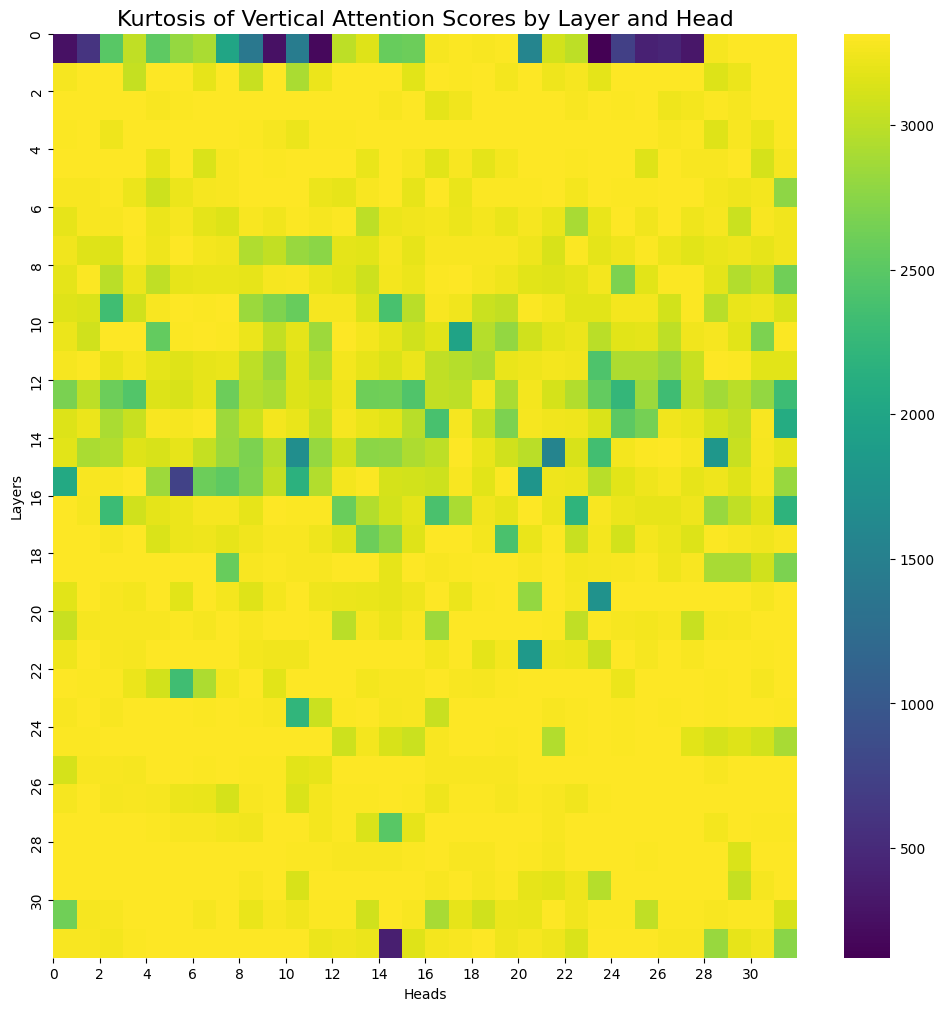

In [23]:
plt.figure(figsize=(12, 12))
sns.heatmap(layer_head_kurtosis, cmap='viridis', annot=False, fmt=".2f")
plt.title('Kurtosis of Vertical Attention Scores by Layer and Head', fontsize=16)
plt.xlabel('Heads')
plt.ylabel('Layers')
plt.xticks(np.arange(0, 32, 2), np.arange(0, 32, 2))
plt.yticks(np.arange(0, 32, 2), np.arange(0, 32, 2))
plt.show()

In [23]:
num_top = 20  # Number of heads to select
# Flatten and get indices of top 20 kurtosis values
flat_indices = np.argsort(layer_head_kurtosis.flatten())[::-1][:num_top]
layer_indices, head_indices = np.unravel_index(flat_indices, layer_head_kurtosis.shape)
top_20_heads = list(zip(layer_indices, head_indices))

print("Top 20 heads by kurtosis (layer, head):")
for i, (layer, head) in enumerate(top_20_heads):
    print(f"{i+1:2d}: Layer {layer}, Head {head}, Kurtosis: {layer_head_kurtosis[layer, head]:.3f}")

Top 20 heads by kurtosis (layer, head):
 1: Layer 4, Head 12, Kurtosis: 3315.997
 2: Layer 1, Head 20, Kurtosis: 3315.996
 3: Layer 3, Head 18, Kurtosis: 3315.996
 4: Layer 25, Head 20, Kurtosis: 3315.977
 5: Layer 3, Head 17, Kurtosis: 3315.970
 6: Layer 3, Head 4, Kurtosis: 3315.958
 7: Layer 29, Head 24, Kurtosis: 3315.956
 8: Layer 25, Head 22, Kurtosis: 3315.951
 9: Layer 1, Head 26, Kurtosis: 3315.936
10: Layer 1, Head 13, Kurtosis: 3315.917
11: Layer 1, Head 18, Kurtosis: 3315.903
12: Layer 29, Head 27, Kurtosis: 3315.902
13: Layer 29, Head 25, Kurtosis: 3315.878
14: Layer 23, Head 29, Kurtosis: 3315.871
15: Layer 29, Head 26, Kurtosis: 3315.869
16: Layer 28, Head 5, Kurtosis: 3315.808
17: Layer 28, Head 22, Kurtosis: 3315.804
18: Layer 22, Head 20, Kurtosis: 3315.793
19: Layer 24, Head 9, Kurtosis: 3315.783
20: Layer 7, Head 5, Kurtosis: 3315.768


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
flat_kurtosis = layer_head_kurtosis.flatten()
plt.figure(figsize=(10,6))
plt.hist(flat_kurtosis, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Kurtosis Scores for All (Layer, Head) Pairs')
plt.xlabel('Kurtosis')
plt.ylabel('Count')
# Plot percentiles
for p in [50, 75, 90, 95, 99]:
    perc = np.percentile(flat_kurtosis, p)
    plt.axvline(perc, color='red', linestyle='--', label=f'{p}th percentile: {perc:.2f}')
plt.legend()
plt.show()

In [24]:
# Define the layer and head you want to visualize
layer_index = 4
head_index = 12

# Extract the attention pattern for the specified layer and head
if layer_index < len(attention_weights):
    layer_attention = attention_weights[layer_index]
    # Squeeze the batch dimension
    attention_pattern = layer_attention.squeeze(0)
    # Get the specific head's attention matrix and detach from the graph
    head_attention = attention_pattern[head_index].detach().numpy()

    # Create the heatmap visualization
    plt.figure(figsize=(10, 8))
    # sns.heatmap(head_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    sns.heatmap(head_attention, cmap='viridis')
    plt.title(f'Attention Head {head_index} in Layer {layer_index}')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Invalid layer index.")

TypeError: Got unsupported ScalarType BFloat16